In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import poligrain as plg
import xarray as xr
import numpy as np

import os

In [3]:
ds_pws = xr.open_dataset('netatmo_kr7_qc_input_file.nc')
ds_pws

<xarray.Dataset> Size: 134MB
Dimensions:       (time: 8833, id: 758)
Coordinates:
  * time          (time) datetime64[ns] 71kB 2015-06-01T00:15:00 ... 2015-09-...
  * id            (id) <U16 49kB 'Netatmo_SE000012' 'Netatmo_SE000021' ... '728'
    latitude      (id) float64 6kB ...
    longitude     (id) float64 6kB ...
    x             (id) float64 6kB ...
    y             (id) float64 6kB ...
Data variables:
    rainfall      (id, time) float64 54MB ...
    nbrs_not_nan  (id, time) int32 27MB ...
    reference     (id, time) float64 54MB ...

In [4]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:3006"
)

In [4]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)
distance_matrix

<xarray.DataArray (id: 758, id_neighbor: 758)> Size: 5MB
array([[    0.        , 17443.08139645,  8984.38269696, ...,
        25750.11331331, 25460.03718499, 25460.03718499],
       [17443.08139645,     0.        , 21529.9397767 , ...,
        23336.23227863, 23179.02259166, 23179.02259166],
       [ 8984.38269696, 21529.9397767 ,     0.        , ...,
        20078.20602366, 19774.27544218, 19774.27544218],
       ...,
       [25750.11331331, 23336.23227863, 20078.20602366, ...,
            0.        ,   303.93660638,   303.93660638],
       [25460.03718499, 23179.02259166, 19774.27544218, ...,
          303.93660638,     0.        ,     0.        ],
       [25460.03718499, 23179.02259166, 19774.27544218, ...,
          303.93660638,     0.        ,     0.        ]])
Coordinates:
  * id           (id) <U16 49kB 'Netatmo_SE000012' 'Netatmo_SE000021' ... '728'
  * id_neighbor  (id_neighbor) <U16 49kB 'Netatmo_SE000012' ... '728'

In [5]:
max_distance = 10e3

### FZ filter

In [6]:
def fz_filter(
    ds_pws,
    nint,
    n_stat):

    pws_data=ds_pws.rainfall
    nbrs_not_nan=ds_pws.nbrs_not_nan
    reference=ds_pws.reference

    # find first rainfall observation in each time series
    first_non_nan_index = ds_pws["rainfall"].notnull().argmax(dim="time")

    # Create a mask that is True up to the first valid index for each station, False afterward
    mask = xr.DataArray(
    np.arange(ds_pws.sizes["time"]), dims="time"
    ) < first_non_nan_index.broadcast_like(ds_pws["rainfall"])

    # initialize arrays
    sensor_array = np.empty_like(pws_data)
    ref_array = np.empty_like(pws_data)
    fz_array = np.empty_like(pws_data)

    # Wet timestep at each station
    sensor_array[np.where(pws_data > 0)] = 1

    # Dry timestep at each station
    sensor_array[np.where(pws_data == 0)] = 0
 
    # Wet timesteps of the reference
    ref_array[np.where(reference > 0)] = 1

    for i in np.arange(len(pws_data.id.data)):
        for j in np.arange(len(pws_data.time.data)):
            if j < nint:
                fz_array[i, j] = -1
            elif sensor_array[i, j] > 0:
                fz_array[i, j] = 0
            elif fz_array[i, j - 1] == 1:
                fz_array[i, j] = 1
            elif (np.sum(sensor_array[i, j - nint : j + 1]) > 0) or (
                np.sum(ref_array[i, j - nint : j + 1]) < nint + 1
            ):
                fz_array[i, j] = 0
            else:
                fz_array[i, j] = 1

    fz_array = fz_array.astype(int)
    fz_flag = xr.where(nbrs_not_nan < n_stat, -1, fz_array)

    # add to dataset
    ds_pws["fz_flag"] = fz_flag

    # set fz_flag to -1 up to the first valid rainfall observation
    ds_pws["fz_flag"] = ds_pws["fz_flag"].where(~mask, -1)

    # check if last nint timesteps are NaN in rolling window
    nan_in_last_nint = ds_pws["rainfall"].rolling(time=nint, center=True).construct("window_dim")
    all_nan_in_window = nan_in_last_nint.isnull().all(dim="window_dim")
    
    # Apply the mask to set fz_flag to -1 where the condition is met
    ds_pws["fz_flag"] = ds_pws["fz_flag"].where(~all_nan_in_window, -1)
    
    return ds_pws

In [7]:
%%time

ds_pws_filtered = fz_filter(
    ds_pws = ds_pws,
    nint=2,
    n_stat = 5)

Wall time: 43 s


In [ ]:
# nint = 2 for 15 minute data means 30 min
# nint = 6 for 5 minute data means 30 min

#### HI filter

In [8]:
def hi_filter(
    ds_pws,
    hi_thres_a,
    hi_thres_b,
    nint,
    n_stat,
):

    # find first rainfall observation in each time series
    first_non_nan_index = ds_pws["rainfall"].notnull().argmax(dim="time")

    # Create a mask that is True up to the first valid index for each station, False afterward
    mask = xr.DataArray(
    np.arange(ds_pws.sizes["time"]), dims="time"
    ) < first_non_nan_index.broadcast_like(ds_pws["rainfall"])
    
    condition1 = (ds_pws.reference < hi_thres_a) & (ds_pws.rainfall > hi_thres_b)
    condition2 = (ds_pws.reference >= hi_thres_a) & (
        ds_pws.rainfall > ds_pws.reference * hi_thres_b / hi_thres_a
    )

    hi_array = (condition1 | condition2).astype(int)

    hi_flag = xr.where(ds_pws.nbrs_not_nan < n_stat, -1, hi_array)

    # add to dataset
    ds_pws["hi_flag"] = hi_flag

    # set hi_flag to -1 up to the first valid rainfall observation
    ds_pws["hi_flag"] = ds_pws["hi_flag"].where(~mask, -1)

    # check if last nint timesteps are NaN in rolling window
    nan_in_last_nint = ds_pws["rainfall"].rolling(time=nint, center=True).construct("window_dim")
    all_nan_in_window = nan_in_last_nint.isnull().all(dim="window_dim")
    
    # Apply the mask to set hi_flag to -1 where the condition is met
    ds_pws["hi_flag"] = ds_pws["hi_flag"].where(~all_nan_in_window, -1)
    
    return ds_pws

In [9]:
ds_pws_filtered = hi_filter(
    ds_pws = ds_pws,
    hi_thres_a = 0.4,
    hi_thres_b = 10,
    nint = 2,
    n_stat = 5)

In [10]:
#ds_pws_filtered.to_netcdf('v2_kr7_only_FZ_HIflags.nc')
ds_pws_filtered

<xarray.Dataset> Size: 188MB
Dimensions:       (time: 8833, id: 758)
Coordinates:
  * time          (time) datetime64[ns] 71kB 2015-06-01T00:15:00 ... 2015-09-...
  * id            (id) <U16 49kB 'Netatmo_SE000012' 'Netatmo_SE000021' ... '728'
    latitude      (id) float64 6kB 57.72 57.58 57.77 57.73 ... 57.71 57.71 57.71
    longitude     (id) float64 6kB 12.37 12.25 12.26 11.95 ... 11.94 11.95 11.95
    x             (id) float64 6kB 3.435e+05 3.356e+05 ... 3.181e+05 3.181e+05
    y             (id) float64 6kB 6.401e+06 6.385e+06 ... 6.4e+06 6.4e+06
Data variables:
    rainfall      (id, time) float64 54MB 0.808 0.606 0.404 ... 53.56 3.758
    nbrs_not_nan  (id, time) int32 27MB 3 3 3 3 3 3 ... 358 358 358 358 358 358
    reference     (id, time) float64 54MB 1.212 1.111 0.606 ... 59.94 3.777
    fz_flag       (id, time) int32 27MB -1 -1 -1 -1 -1 -1 -1 ... 0 0 0 0 0 0 0
    hi_flag       (id, time) int32 27MB -1 -1 -1 -1 -1 -1 -1 ... 0 0 0 0 0 0 0

### SO filter

In [11]:
ds_pws_filtered['so_flag'] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))
ds_pws_filtered['median_corr_nbrs'] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))

In [12]:
# For each station (ID), get the index of the first non-NaN rainfall value
first_non_nan_index = ds_pws["rainfall"].notnull().argmax(dim="time")

In [13]:
mint = 2880
mmatch = 100
gamma = 0.15 
n_stat = 5
max_distance = 10e3 

In [14]:
def so_filter(da_station, da_neighbors, window_length):

    # rolling pearson correlation
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()
    corr = s_station.rolling(window_length, min_periods= 1).corr(s_neighbors)
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'corr': corr}))

    # create dataframe of neighboring stations
    df = da_neighbors.to_dataframe()
    df = df["rainfall"].unstack("id")

    # boolean arrays - True if a rainy time step, False if 0 or NaN.
    rainy_timestep_at_nbrs = (df > 0)
    
    # rolling sum of number of rainy timesteps in last mint period, per neighbor. 
    wet_timesteps_last_mint_period = rainy_timestep_at_nbrs.rolling(mint, min_periods=1).sum()
    
    # per time step and neighbor, does the nbr have more than mmatch wet time steps in the last mint period? (true/false)
    enough_matches_per_nbr = (wet_timesteps_last_mint_period > mmatch)
    
    # summing how many neighbors that have enough matches per time step
    nr_nbrs_with_enough_matches = enough_matches_per_nbr.sum(axis = 1)

    ds['matches'] = xr.DataArray.from_series(nr_nbrs_with_enough_matches)
    
    return ds

In [15]:
%%time

for i in range(len(ds_pws.id)):
    
    ds_station = ds_pws.isel(id=i)
    pws_id = ds_station.id.values

    # picking stations within max_distnance, excluding itself, for the whole duration of the time series
    neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]

    #create data set for neighbors
    #ds_neighbors = ds_pws.sel(id=neighbor_ids).sel(time = slice('2016-05-01T00:05:00','2016-05-01T06:05:00'))
    ds_neighbors = ds_pws.sel(id=neighbor_ids)

    # if there are no observations in the time series, filter cannot be applied to the whole time series
    if ds_pws.rainfall.sel(id=pws_id).isnull().all():
        ds_pws_filtered.so_flag[i, :] = -1
        ds_pws_filtered.median_corr_nbrs[i,:] = -1
        continue

    # if there are not enough stations nearby, filter cannot be applied to the whole time series
    elif (len(neighbor_ids) < n_stat):
        ds_pws_filtered.so_flag[i, :] = -1
        ds_pws_filtered.median_corr_nbrs[i,:] = -1
        continue 
        
    else: 
    # run so-filter
        ds_so_filter = so_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)

        median_correlation = ds_so_filter.corr.median(dim='id', skipna = True)
        ds_pws_filtered.median_corr_nbrs[i] = median_correlation
        
        so_array = (median_correlation < gamma).astype(int)
        
    # filter can not be applied if less than n_stat neighbors have enough matches
        ds_pws_filtered.so_flag[i] = xr.where(ds_so_filter.matches < n_stat, -1, so_array)

    # Set so_flag to -1 up to first valid index
        first_valid_time = first_non_nan_index[i].item()
        ds_pws_filtered["so_flag"][i, :first_valid_time] = -1 

    # disregard warm up period
        ds_pws_filtered.so_flag[i, first_valid_time:(first_valid_time+mint)] = -1

ds_pws_filtered.to_netcdf('QC_netatmo_kr7.nc')

Wall time: 16min 32s


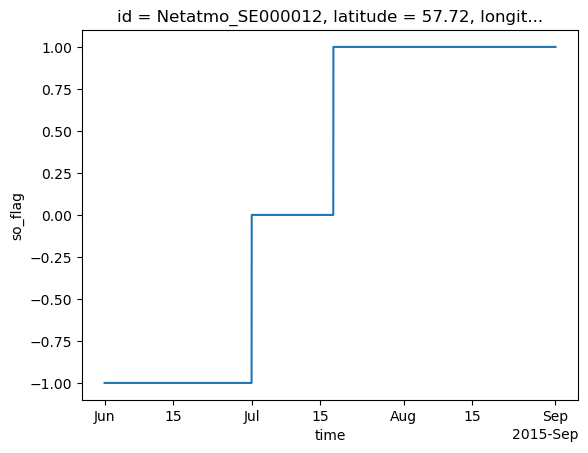

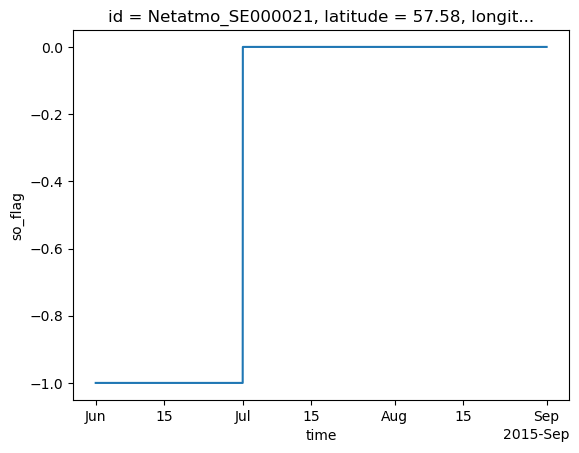

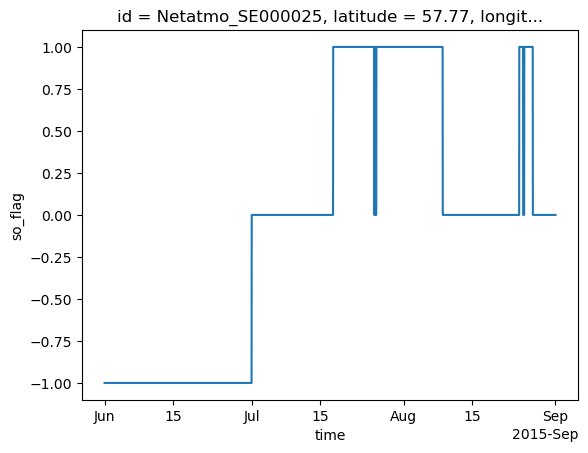

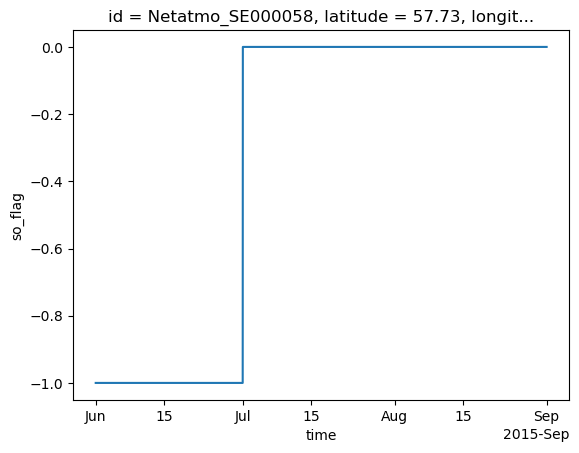

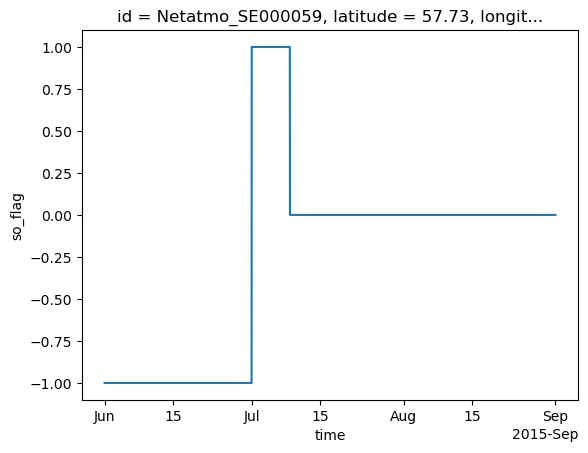

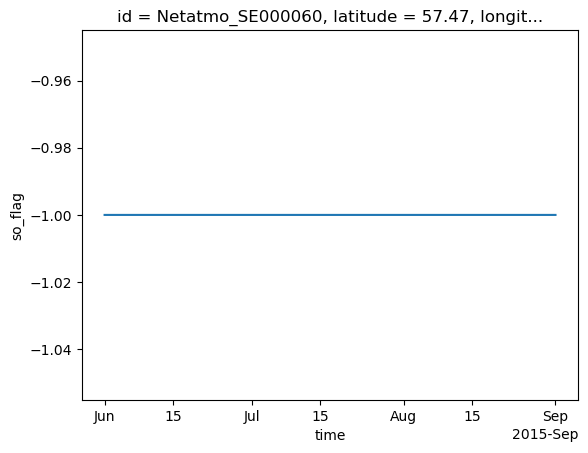

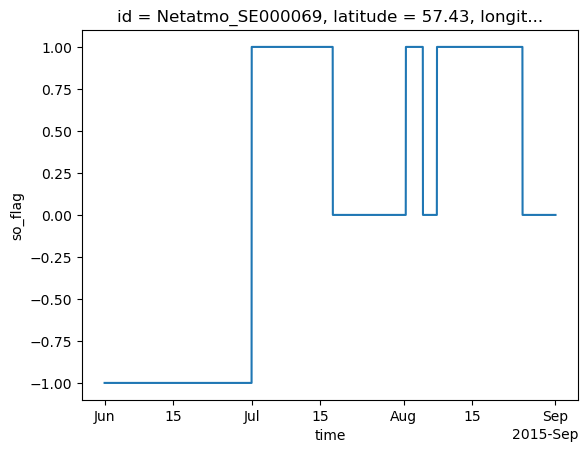

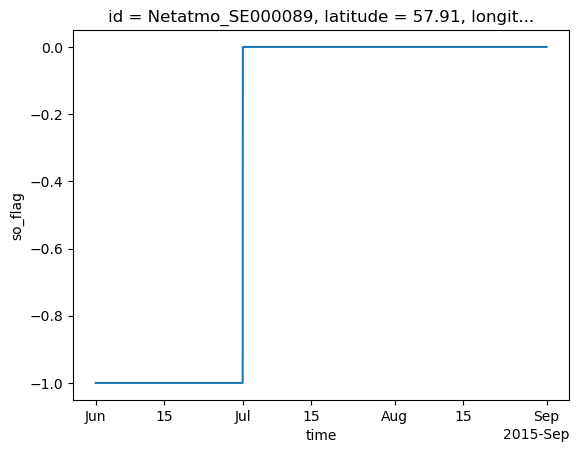

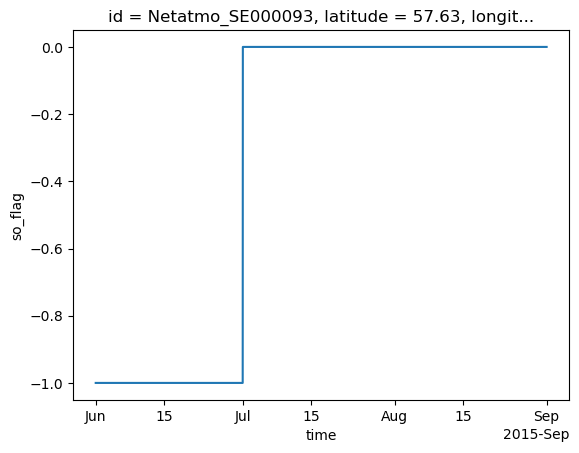

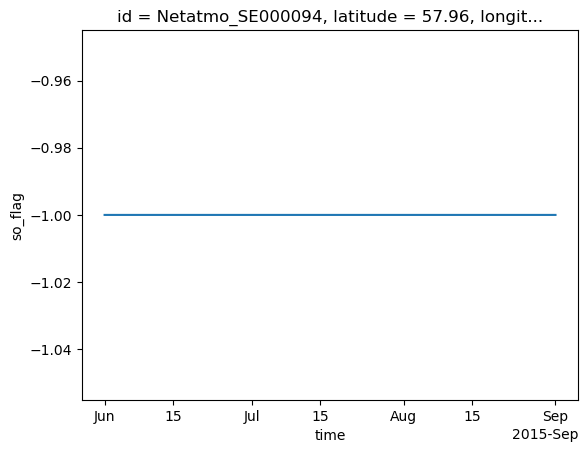

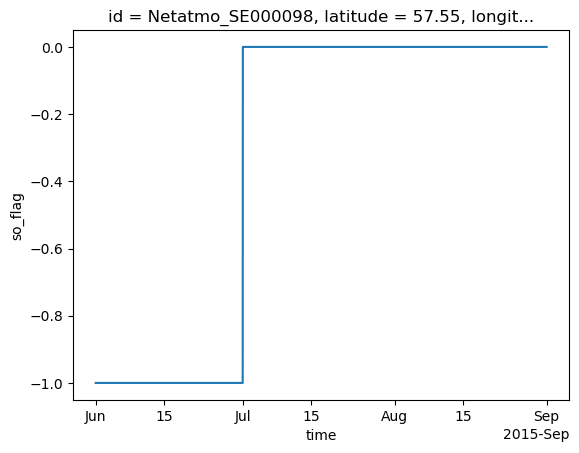

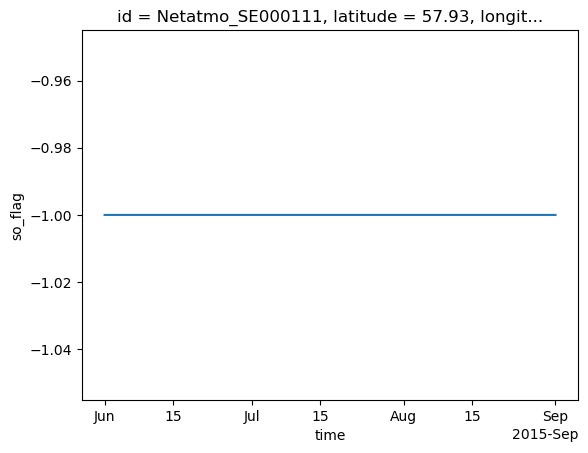

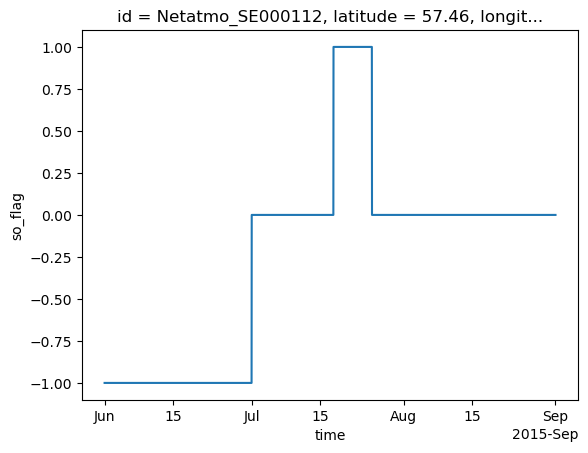

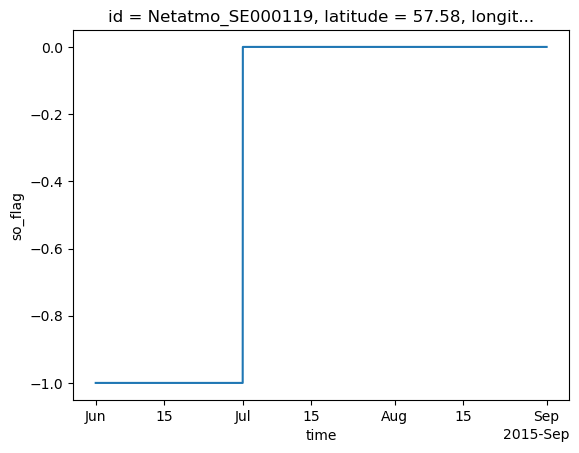

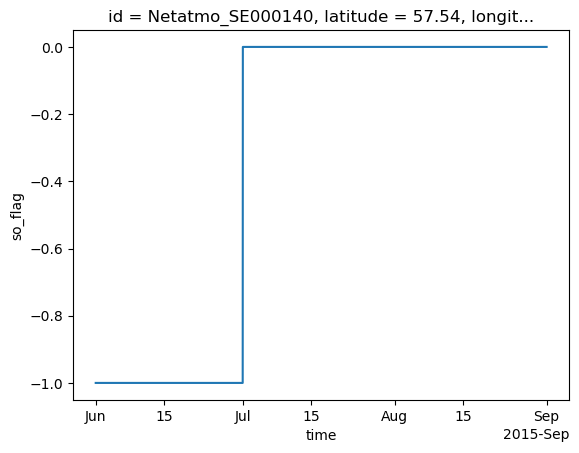

In [18]:
for i in np.arange(0,15):
    plt.figure()
    ds_pws_filtered.so_flag.isel(id = i).plot()